In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

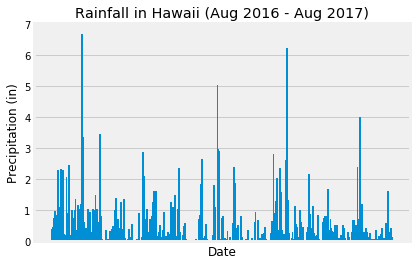

In [76]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores

prcp = []

for row in session.query(Measurement.prcp, Measurement.date):
    x = dt.date.fromisoformat(row[1])
    
    if x.year == 2017:
        prcp.append(row)
        
    if x.year == 2016 and x.month in [9, 10, 11, 12]:
        prcp.append(row)
        
    if x.year == 2016 and x.month == 8\
    and x.day >= 12:
        prcp.append(row)                 
                   
# Save the query results as a Pandas DataFrame and set the index to the date column

hi_rain = pd. DataFrame(prcp)
hi_rain = hi_rain.set_index(hi_rain.date)
hi_rain = hi_rain.drop("date", 1)

# Sort the dataframe by date
hawaii_rain = hi_rain.sort_values(by=["date"])

# Use Pandas Plotting with Matplotlib to plot the data
dates = hi_rain.index
rain = hi_rain["prcp"].tolist()

plt.bar(dates, rain, width=2)
plt.title("Rainfall in Hawaii (Aug 2016 - Aug 2017)")
plt.xlabel("Date")
plt.ylabel("Precipitation (in)")
plt.xticks([])
plt.grid(True)
plt.show()

![precipitation](Images/precipitation.png)

In [37]:
# Use Pandas to calcualte the summary statistics for the precipitation data
hi_rain.describe()

,prcp
count,2086.000000
mean,0.179377
std,0.461432
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [38]:
# Design a query to show how many stations are available in this dataset?
len([i for i in session.query(Station)])

9

In [39]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
from sqlalchemy import desc

result = session.query(Measurement.station, func.count(Measurement.date).label('count'))\
.group_by(Measurement.station)\
.order_by(desc('count')).all()

result

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [33]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
result = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
.filter(Measurement.station=="USC00519281").all()

result

[(54.0, 85.0, 71.66378066378067)]

<function matplotlib.pyplot.show(*args, **kw)>

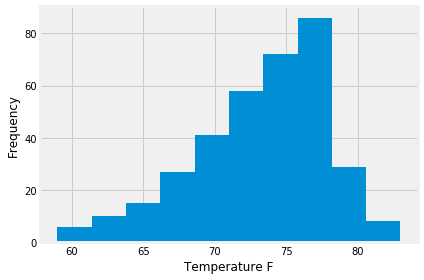

In [77]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs = []

for row in session.query(Measurement.tobs, Measurement.date).filter(Measurement.station=="USC00519281"):
    x = dt.date.fromisoformat(row[1])

    if x.year == 2017:
        tobs.append(row[0])
        
    if x.year == 2016 and x.month in [9, 10, 11, 12]:
        tobs.append(row[0])
    
    if x.year == 2016 and x.month == 8 \
    and x.day >= 23:
        tobs.append(row[0])
        
plt.hist(tobs)
plt.ylabel("Frequency")
plt.xlabel("Temperature F")
plt.tight_layout()
plt.show

![precipitation](Images/station-histogram.png)

In [87]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

 #TMIN, TAVG, and TMAX for a list of dates
    
 #Args:
 #start_date (string): A date string in the format %Y-%m-%d
 #end_date (string): A date string in the format %Y-%m-%d
        
    #Returns:
       #TMIN, TAVE, and TMAX

def calc_temps(start_date, end_date):
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-08-15', '2016-08-30'))

[(71.0, 78.07692307692308, 84.0)]


In [88]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-08-15', '2017-08-30'))

[(70.0, 78.51428571428572, 85.0)]


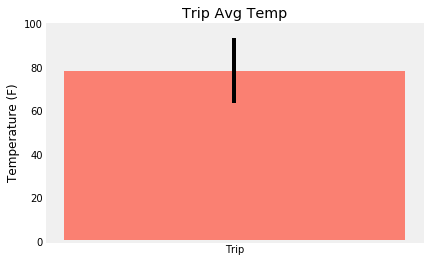

In [89]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
my_temps = calc_temps('2017-08-15', '2017-08-30')
my_temps = [i for i in my_temps[0]]
error = my_temps[2] - my_temps[0]

plt.bar(["Trip"], my_temps[1], width=0.25, color="salmon", yerr=error)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")
plt.ylim(0, 100)
plt.grid()
plt.show()

In [91]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation.


engine.execute('select Measurement.station, sum(Measurement.prcp) as total, Station.name, Station.latitude, \
                    Station.longitude, Station.elevation \
                from Measurement \
                inner join Station on Station.station=Measurement.station \
                where Measurement.date = "2017-08-15" \
                or Measurement.date = "2017-08-16" \
                or Measurement.date = "2017-08-17" \
                or Measurement.date = "2017-08-18" \
                or Measurement.date = "2017-08-19" \
                or Measurement.date = "2017-08-20" \
                or Measurement.date = "2017-08-21" \
                or Measurement.date = "2017-08-22" \
                or Measurement.date = "2017-08-23" \
                or Measurement.date = "2017-08-24" \
                or Measurement.date = "2017-08-25" \
                or Measurement.date = "2017-08-26" \
                or Measurement.date = "2017-08-27" \
                or Measurement.date = "2017-08-28" \
                or Measurement.date = "2017-08-29" \
                or Measurement.date = "2017-08-30" \
                group by Measurement.station \
                order by Measurement.prcp desc;').fetchall()

[('USC00516128', 2.5700000000000003, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00519523', 0.26, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 ('USC00519281', 0.51, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00514830', 0.03, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 ('USC00519397', 0.02, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)]

# Optional Challenge Assignment

In [72]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("11-15")

[(65.0, 73.67924528301887, 79.0)]

In [95]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
trip_start_date = "2019-08-15"
trip_end_date = "2019-08-30"

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(trip_start_date, trip_end_date, freq = "D")

# Stip off the year and save a list of %m-%d strings
trip_month_day = trip_dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in trip_month_day:
    normals.append(*daily_normals(date))
    
normals

[(69.0, 76.47169811320755, 83.0),
 (69.0, 76.08, 83.0),
 (69.0, 76.125, 83.0),
 (70.0, 76.92307692307692, 84.0),
 (69.0, 75.94642857142857, 85.0),
 (68.0, 76.45283018867924, 82.0),
 (67.0, 76.4, 83.0),
 (69.0, 76.47169811320755, 84.0),
 (67.0, 76.6923076923077, 87.0),
 (70.0, 75.96153846153847, 84.0),
 (69.0, 76.96078431372548, 82.0),
 (71.0, 76.56862745098039, 84.0),
 (68.0, 76.28301886792453, 84.0),
 (67.0, 76.73469387755102, 86.0),
 (70.0, 76.23529411764706, 85.0),
 (68.0, 76.41666666666667, 84.0)]

In [97]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df['date'] = trip_dates
df.set_index(['date'],inplace=True)
df.head(16)

,tmin,tavg,tmax
date,,,
2019-08-15,69.0,76.471698,83.0
2019-08-16,69.0,76.080000,83.0
2019-08-17,69.0,76.125000,83.0
2019-08-18,70.0,76.923077,84.0
2019-08-19,69.0,75.946429,85.0
2019-08-20,68.0,76.452830,82.0
2019-08-21,67.0,76.400000,83.0
2019-08-22,69.0,76.471698,84.0
2019-08-23,67.0,76.692308,87.0


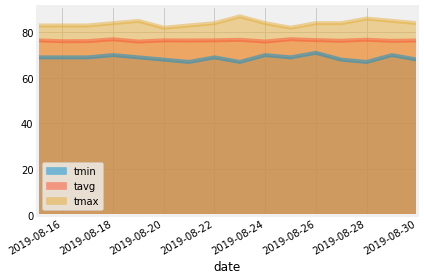

In [100]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area', stacked=False, x_compat=True, alpha=.5)
plt.tight_layout()